<H1>Lab 5 - Explainability in Machine Learning</H1>
*Week 5 - PM034A Machine learning for socio-technical systems*

By **Nadia Metoui**<br>
Faculty of Technology, Policy, and Management (TPM)<br>

***Learning Objectives***<br>
Implement and Examine Intrinsic Explainable ML Models. <br>
Implement and Examine Post-Hoc Explainability  Models. <br>
Discuss explainability in a Multi-stakeholders Socio-Technical context.


## Part 0. Setting up the Lab:
Step 1: Install and Load the libraries for the Lab.<br>
Step 2: Load and Prepare the Data.<br>
Step 3: Familiarize with the dataset <br>
Step 4: Train the ML model <br>

###Step 1: Install and Load the libraries for the Lab.



In [6]:
!pip install lime
!pip install shap

In [7]:
%matplotlib inline

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import warnings
import lime
import lime.lime_tabular
from lime import submodular_pick
import shap
from shap.plots import _waterfall
import xgboost
from xgboost import plot_importance
import json
from collections import OrderedDict


import pandas as pd

np.random.seed(1)

###Step 2: Load and Prepare the Data.


We will be using the **Adult Dataset** ([full documentation here](https://archive.ics.uci.edu/ml/datasets/adult)), which is an "Census Income" dataset (USA). We will use this dataset predict whether a person makes over 50K dollars per year based on census information (e.g., age, education, country of birth etc.). We will be using the version of the dataset hosted online [here](https://archive.ics.uci.edu/ml/datasets/adult).

#### Load the dataset:
We will download the dataset directly from the online archive.<br>
Name the columns. And store the data in a dataframe.


In [8]:
# Name Columns
colnames = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num",
            "Marital-Status", "Occupation", "Relationship", "Race", "Sex",
            "Capital-Gain", "Capital-Loss","Hours-per-week", "Country",
            "income"]

# Load in the data
# If you have any issues downloadting the data replace the link by the adult.data file
data_df = pd.read_csv('data/adult.data',
                      names = colnames)
print("Shape: ", data_df.shape)
data_df.head()

Shape:  (32561, 15)


Age          Workclass  fnlwgt   Education  Education-Num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        Marital-Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital-Gain  Capital-Loss  Hours-per-week         Country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [9]:
# Drop Education-Num, which has a functional dependency with Education
# Same Tuple Values
print("Show functional dependency")
print(data_df.groupby(['Education','Education-Num']).size())
data_df.drop(['Education-Num'], axis=1, inplace=True)

Show functional dependency
Education      Education-Num
 10th          6                  933
 11th          7                 1175
 12th          8                  433
 1st-4th       2                  168
 5th-6th       3                  333
 7th-8th       4                  646
 9th           5                  514
 Assoc-acdm    12                1067
 Assoc-voc     11                1382
 Bachelors     13                5355
 Doctorate     16                 413
 HS-grad       9                10501
 Masters       14                1723
 Preschool     1                   51
 Prof-school   15                 576
 Some-college  10                7291
dtype: int64


In [10]:
# Drop fnlwgt might not be the best choice but I could not figutr out what this attribut stands for
# Better safe than sorry ;-)
data_df.drop(['fnlwgt'], axis=1, inplace=True)

In [11]:
# Get a list of feature names (excluding the outcome variable: income)
feature_names = data_df.columns[:-1]

In [12]:
# Mark labels and encode them using sklearn
labels = data_df.iloc[:,-1]
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data_df.iloc[:,:-1]
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class names: ", class_names)
print("Label mapping: ", le_label_mapping)



Class names:  [' <=50K' ' >50K']
Label mapping:  {' <=50K': 0, ' >50K': 1}


In [13]:
# Check if there are categorical varibles that we need to make dummies for
print(data.dtypes)
# Get a list of which variables are categorical
categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
print("Indices of categorical features: ", categorical_features)

Age                int64
Workclass         object
Education         object
Marital-Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-Gain       int64
Capital-Loss       int64
Hours-per-week     int64
Country           object
dtype: object
Indices of categorical features:  [1, 2, 3, 4, 5, 6, 7, 11]


###Step 3: Familiarize with the dataset. 


In [14]:
print("Shape: ", data_df.shape)
data_df.head()

Shape:  (32561, 13)


Age          Workclass   Education       Marital-Status  \
0   39          State-gov   Bachelors        Never-married   
1   50   Self-emp-not-inc   Bachelors   Married-civ-spouse   
2   38            Private     HS-grad             Divorced   
3   53            Private        11th   Married-civ-spouse   
4   28            Private   Bachelors   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital-Gain  \
0        Adm-clerical   Not-in-family   White     Male          2174   
1     Exec-managerial         Husband   White     Male             0   
2   Handlers-cleaners   Not-in-family   White     Male             0   
3   Handlers-cleaners         Husband   Black     Male             0   
4      Prof-specialty            Wife   Black   Female             0   

   Capital-Loss  Hours-per-week         Country  income  
0             0              40   United-States   <=50K  
1             0              13   United-States   <=50K  
2             0              40   United-States   <=50K  
3             0              40   United-States   <=50K  
4             0              40            Cuba   <=50K

###Step 4: Train the ML model 

####Feature Preparation (Compatible with LIME for Part I and II)
**Note:** in PART II. LIME will require us to provde categorical variables as a single column, not as dummies, so we can't just explode these columns the way we normally would during pre-processing.

To avoid redoing this part for Intrensic and Post-Hoc explanability we will use some sklearn tools and do the following:

1. Encode the existing categories with a number corresponding to each category
2. Make a dictionary storing the relationship between the original stirng category and the number we've replaced it with (categorical_names)
3. Make a function that we can use down the line to transform categorical variables into dummies

In [15]:
categorical_names = {}
for feature in categorical_features:
    print("Feature: ", feature)
    # Use label encoder to map categories to numbers
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data.iloc[:, feature])
    # Replace the categories with corresponding numbers in the original data
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    # Store and print the mappings for reference later
    categorical_names[feature] = le.classes_
    print(categorical_names[feature])
    print("==================================================")


Feature:  1
[' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']
Feature:  2
[' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
Feature:  3
[' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
Feature:  4
[' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sales' ' Tech-support' ' Transport-moving']
Feature:  5
[' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']
Feature:  6
[' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']
Feature:  7
[' Female' ' Male']
Feature:  11
[' ?' ' Cambodia' ' Canada' ' Chi

In [16]:
# This variable is where we store the original names of each category for each variable
categorical_names

{1: array([' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
        ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
       dtype=object),
 2: array([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th',
        ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate',
        ' HS-grad', ' Masters', ' Preschool', ' Prof-school',
        ' Some-college'], dtype=object),
 3: array([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
        ' Married-spouse-absent', ' Never-married', ' Separated',
        ' Widowed'], dtype=object),
 4: array([' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
        ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
        ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
        ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
        ' Transport-moving'], dtype=object),
 5: array([' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
     

In [17]:
# We can (and will) use this encoder function to transform the categorical columns into dummies-- 
# but we can't do that to the original dataset if we want to use LIME After training
encoder = ColumnTransformer(transformers=[('get_dummies', OneHotEncoder(), categorical_features)], remainder='passthrough')
encoder = encoder.fit(data)

#### Split into training and test sets

We will us an 80/20 train-test split. We won't be doing any hyperparameter tuning during this lab, so no need to worry about a validation set. 

In [18]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80, random_state=10)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (26048, 12)
Test shape:  (6513, 12)


####Train the model

We will be using gradient boosted decision trees. Gradient boosting machine learning methods such as XGBoost are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. 
For this Lab we will user an implementation from the [xgboost](https://github.com/dmlc/xgboost) package.

In [19]:
# Fit the model
gbtree = xgboost.XGBClassifier(n_estimators=200, max_depth=5)
gbtree.fit(encoder.transform(train), labels_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [20]:
# Make predictions 
pred_labels_test = gbtree.predict(encoder.transform(test))

# Calcualte accuracy on the test set
print("Test set accuracy: ", sklearn.metrics.accuracy_score(labels_test, pred_labels_test))

Test set accuracy:  0.8687240902809765


## Part I: Intrinsic Explainability
As explained in class some ML models (usually less complex ones) have ability to provide some explanations about decisions these models make without the need for an "external" explainer. Tree-based ML models can provide information about feature importance for the predictions.

In the following we will: 
- Produce measur(s) of feature importance for our gradient boosted decision tree.
- Take a closer look at thes intrensic explanations and discuss the results.

#### Feature importance decision trees (Using Weight)

There are three options (or measurement creteria) for measuring feature importance in XGBoost* (and generally most tree-based models):

1. **Weight:** The number of times a feature is used to split the data across all trees.
2. **Cover:** The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
3. **Gain:**. The average training loss reduction gained when using a feature for splitting.

<small>* Note: A measure of feature importance is calculated for a single tree by counting how many splits occured on each variable (or measurs around a split see above). We calculate at a feature importance for the entire model by averaging the score for each feature across all trees in the forest. </small>


In [21]:
# Prepare for the feature importance plot
# Get feature names for the transformed dataset so that they'll show up on the plot 
gbtree_features_orig = gbtree.get_booster().feature_names
gbtree_features = []
for cat_var in categorical_names:
    cat_var_names = [feature_names[cat_var] +" = " + cat for cat in categorical_names[cat_var]]
    gbtree_features.extend(cat_var_names)
gbtree_features.extend([feature_names[i] for i in range(len(feature_names)) if i not in categorical_features])
gbtree.get_booster().feature_names = gbtree_features

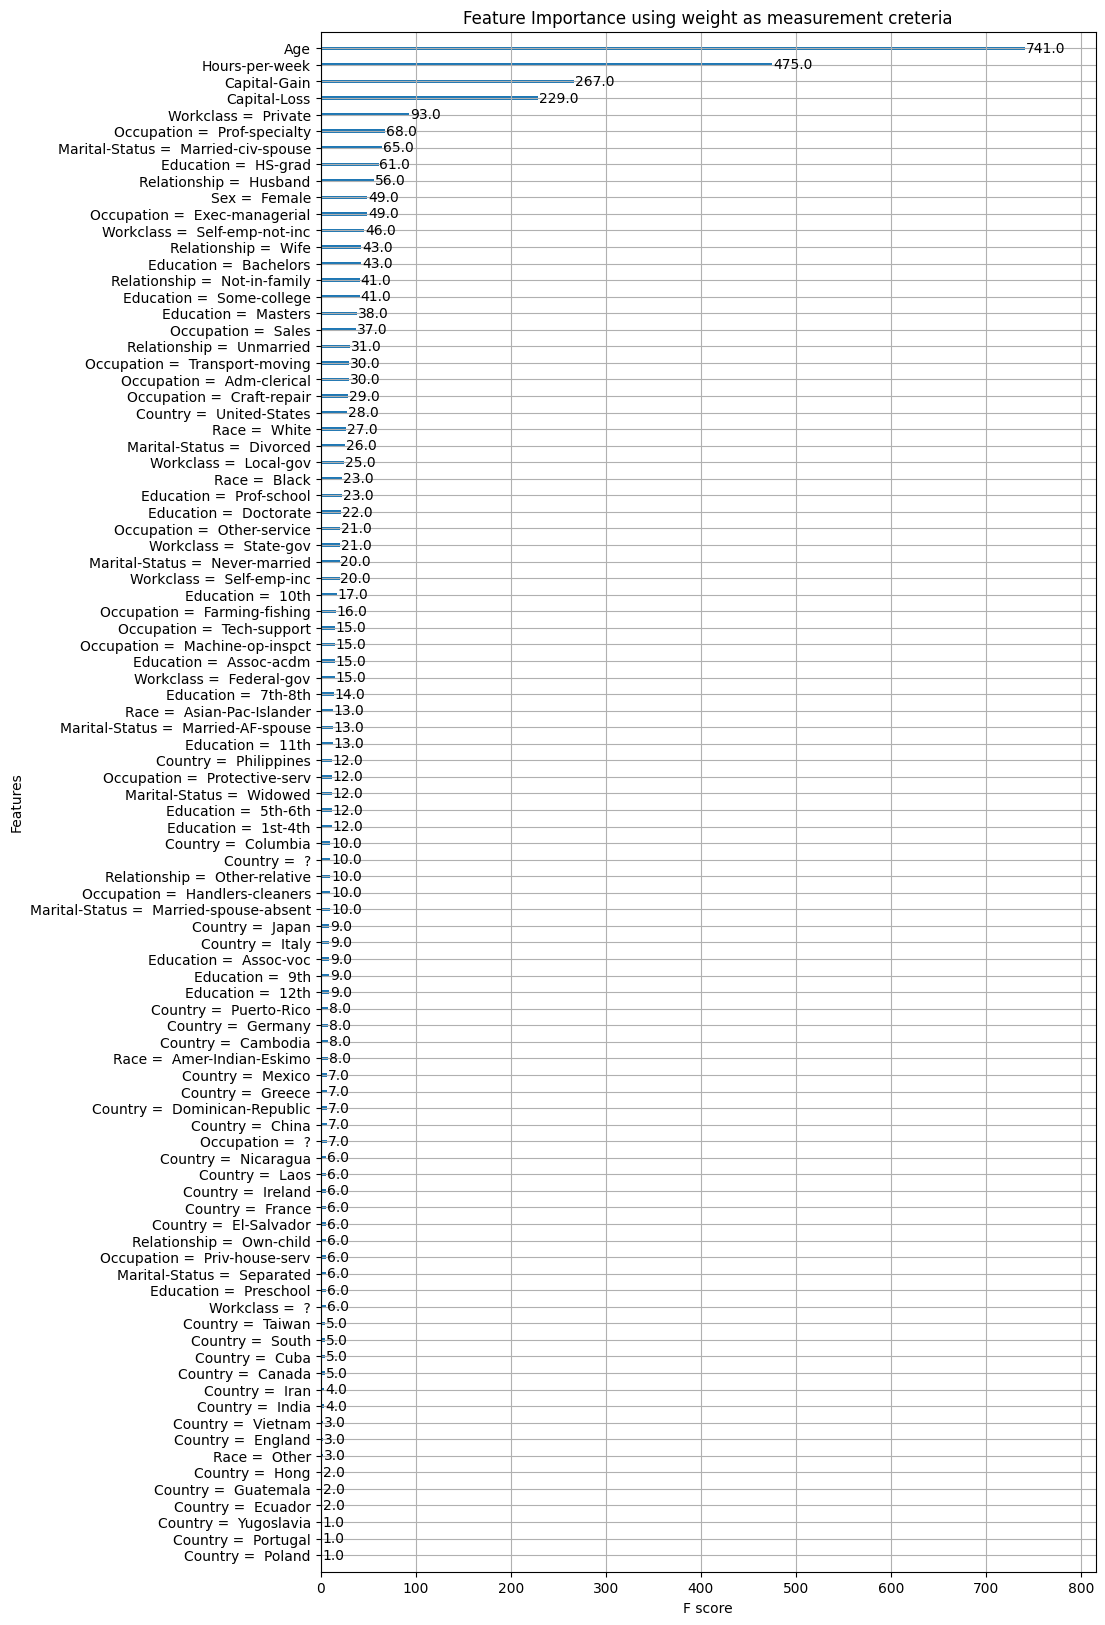

In [22]:
plt.rcParams["figure.figsize"] = (10,20)
xgboost.plot_importance(gbtree, importance_type="weight")
plt.title("Feature Importance using weight as measurement creteria")
plt.show()


**Question:**<br>
1. What did we learn from this plot. How should we read it?
2. What does it not tell us?
3. Who can use these explanations? Which stakeholder?
4. For what purpose(s)?

**Answers**


#### Feature importance decision trees (Change measurement creteria)


The plot_importance function takes a parameter called 'importance_type'(you can read more about [in the documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting)). 

This parameter can take different values depending on the measurement you want to use (*Cover*, *Weight*, *Gain* etc see definitions for each of them above)

Try changing the importance type and re-making the plot

In [23]:
# Your code here (for cove)

In [24]:
# Your code here (for gain)

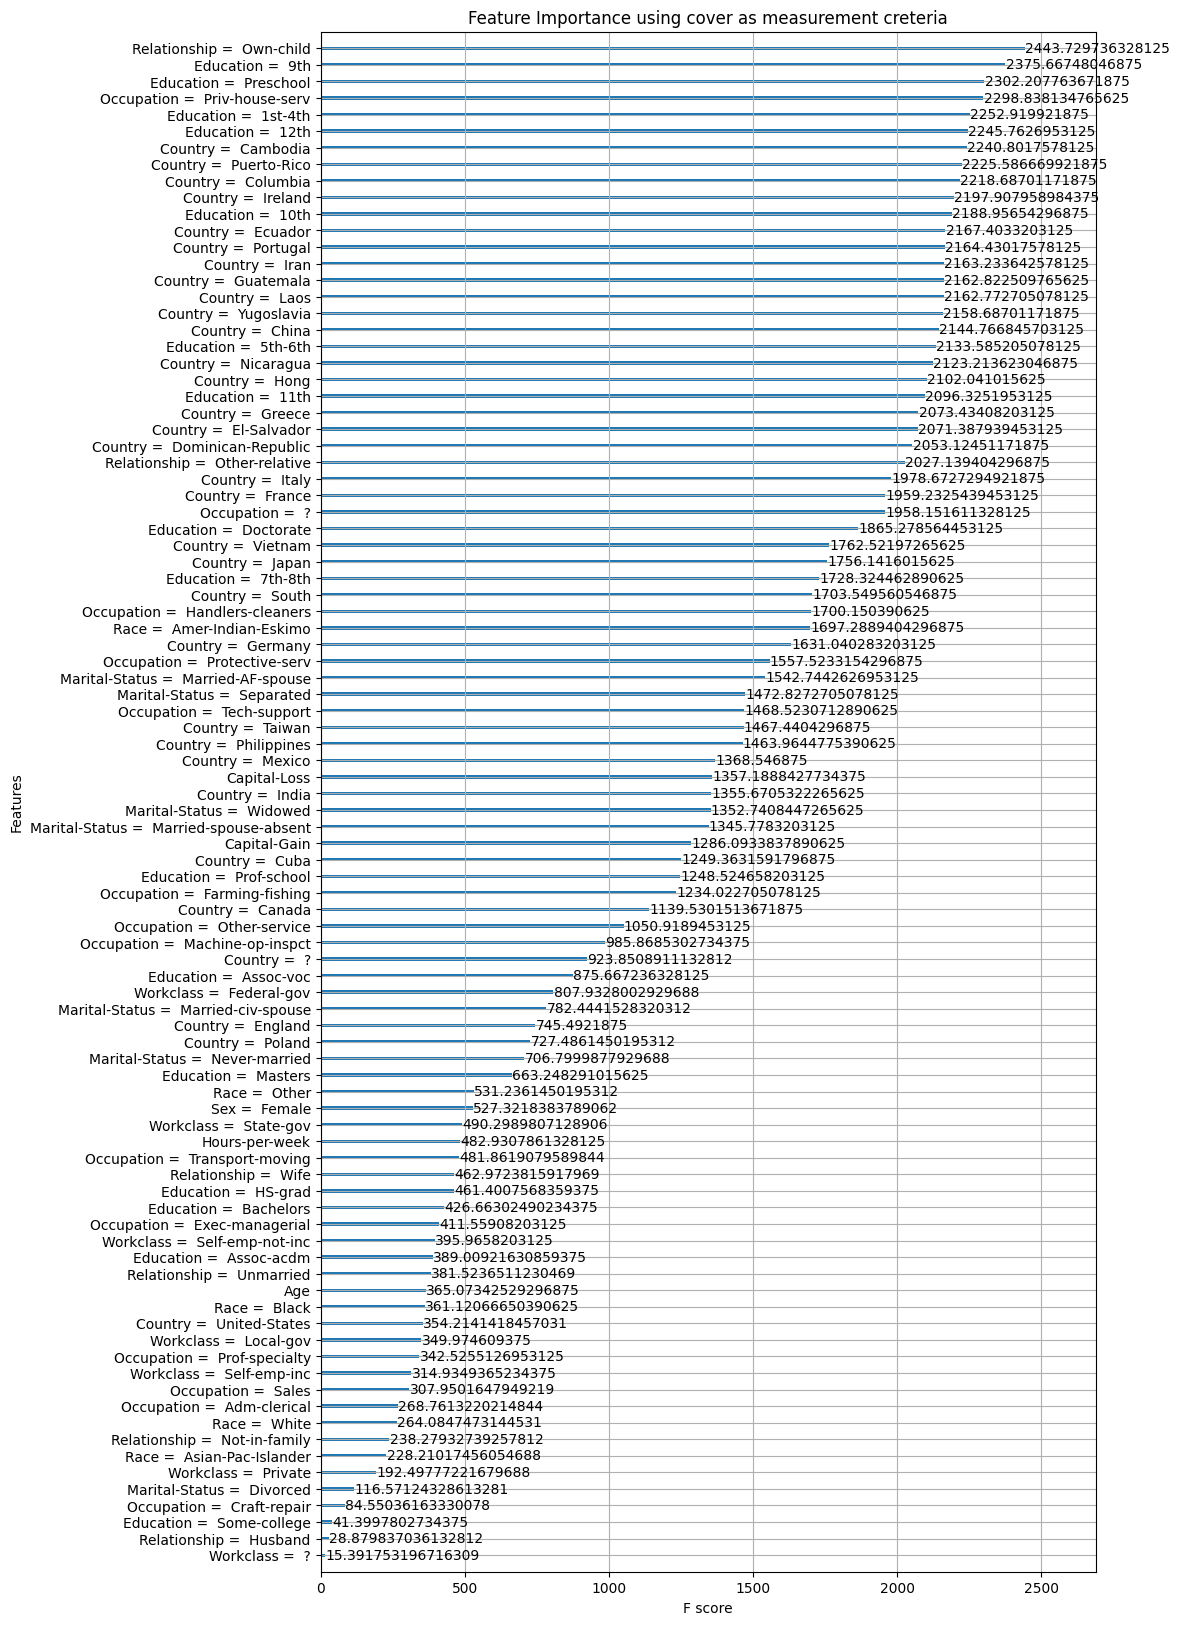

In [25]:
xgboost.plot_importance(gbtree, importance_type="cover")
plt.title("Feature Importance using cover as measurement creteria")
plt.show()

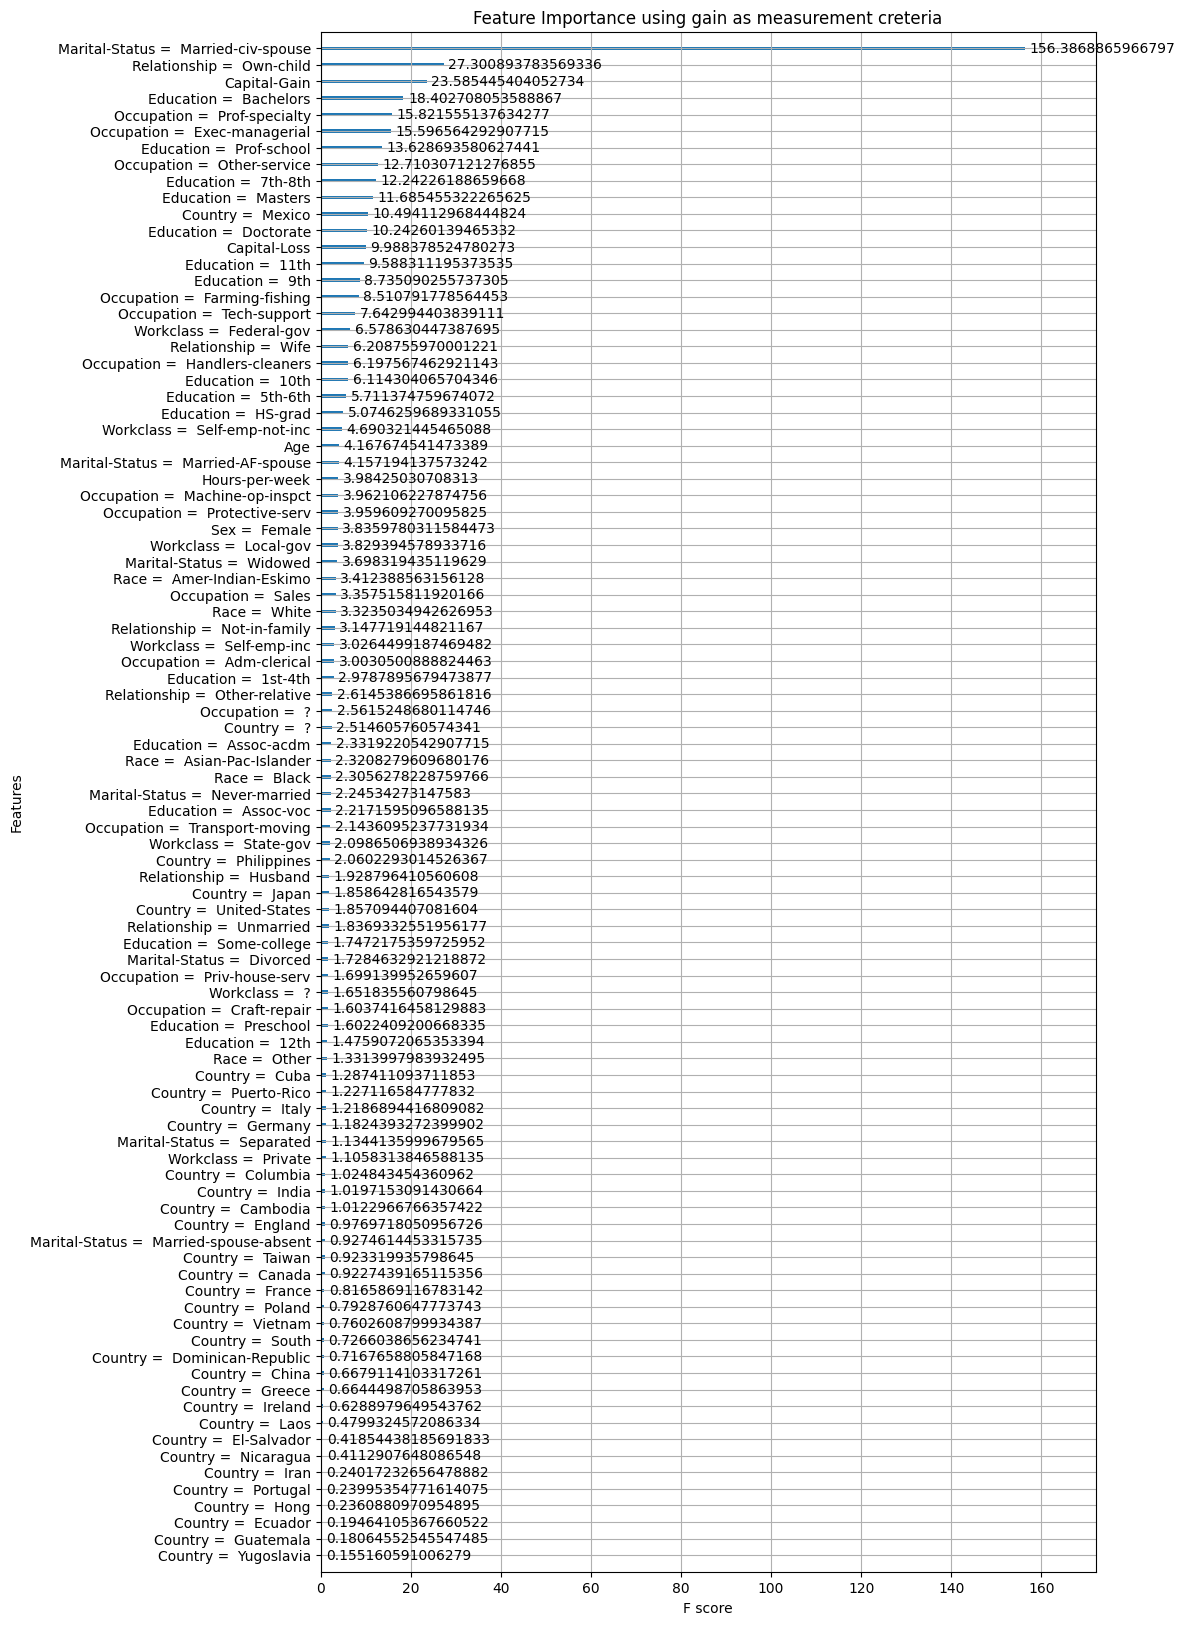

In [26]:
xgboost.plot_importance(gbtree, importance_type="gain")
plt.title("Feature Importance using gain as measurement creteria")
plt.show()

**Questions:**<br>
1. What did you notice using these different measurments of feature importance?
2. What are the conseqences of that?

**Answers**
1. 
2. In short we do not know which explanation to "trust" or to "use"/"relay on". We need the Post-Hoc Explainability tools



## Part II: Post-Hoc Explainability LIME

LIME: Locally Interpetable Model-agnostic Explanations:

- Locally interpretable: for each specific prediction, we can provide a relevant explanation. 
- Model-agnostic: we can provide the same sort of explanation for models of different classes.
- Can be used to produce Global Explanations (using SP-LIME)

LIME has a python implementation package we will be using in this part. For more informations about the package see [full documentation here](https://github.com/marcotcr/lime) and [here](https://lime-ml.readthedocs.io/en/latest/index.html). The original paper describing the LIME method is [here](https://arxiv.org/pdf/1602.04938.pdf).

We will explore both Local and Global LIME Explanations :
- Step 1: LIME Local Explainer (for Tabular Data)
- Step 2: SP-LIME Global Explainer(for Tabular Data)

### Step 1: LIME Local Explainer (for Tabular Data)

Replace the original feature names (to fit LIME expect format for features as discussed above)

In [27]:
# Replace the original feature names, which LIME will expect
gbtree.get_booster().feature_names = gbtree_features_orig

Then, we initialize an explainer object that takes in all the information we stored/encoded earlier about the dataset. 

In [36]:
print(class_names)
print(feature_names)
explainer = lime.lime_tabular.LimeTabularExplainer(train.values, 
                                                   feature_names=feature_names,
                                                   class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names)

[' <=50K' ' >50K']
Index(['Age', 'Workclass', 'Education', 'Marital-Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital-Gain', 'Capital-Loss',
       'Hours-per-week', 'Country'],
      dtype='object')


Then, we need to format data inputs and outputs for LIME (i.e., we need to define a single function that takes in the form of data that LIME expects and returns the type of prediction that LIME expects.) <br> 

In particular:
- the input should be a numpy array (which we can get from a pandas df using .values)
- the input features should be human-understandable
- the input data should have each categorical variable in a single column
- the output should be a predicted probability (not a predicted class) 

In [29]:
predict_fn = lambda x: gbtree.predict_proba(encoder.transform(x)).astype(float)

Now we have everything we need to use the explainer. Let's get an explanation for one of the examples in the test set.

The variable "i" indicates the data point for which we want an explanation

In [30]:
i = 3
print('Actual class: ', labels_test[i])
# Get explanation
exp = explainer.explain_instance((test.values[i]), predict_fn, num_features=5)

Actual class:  0


X does not have valid feature names, but OneHotEncoder was fitted with feature names


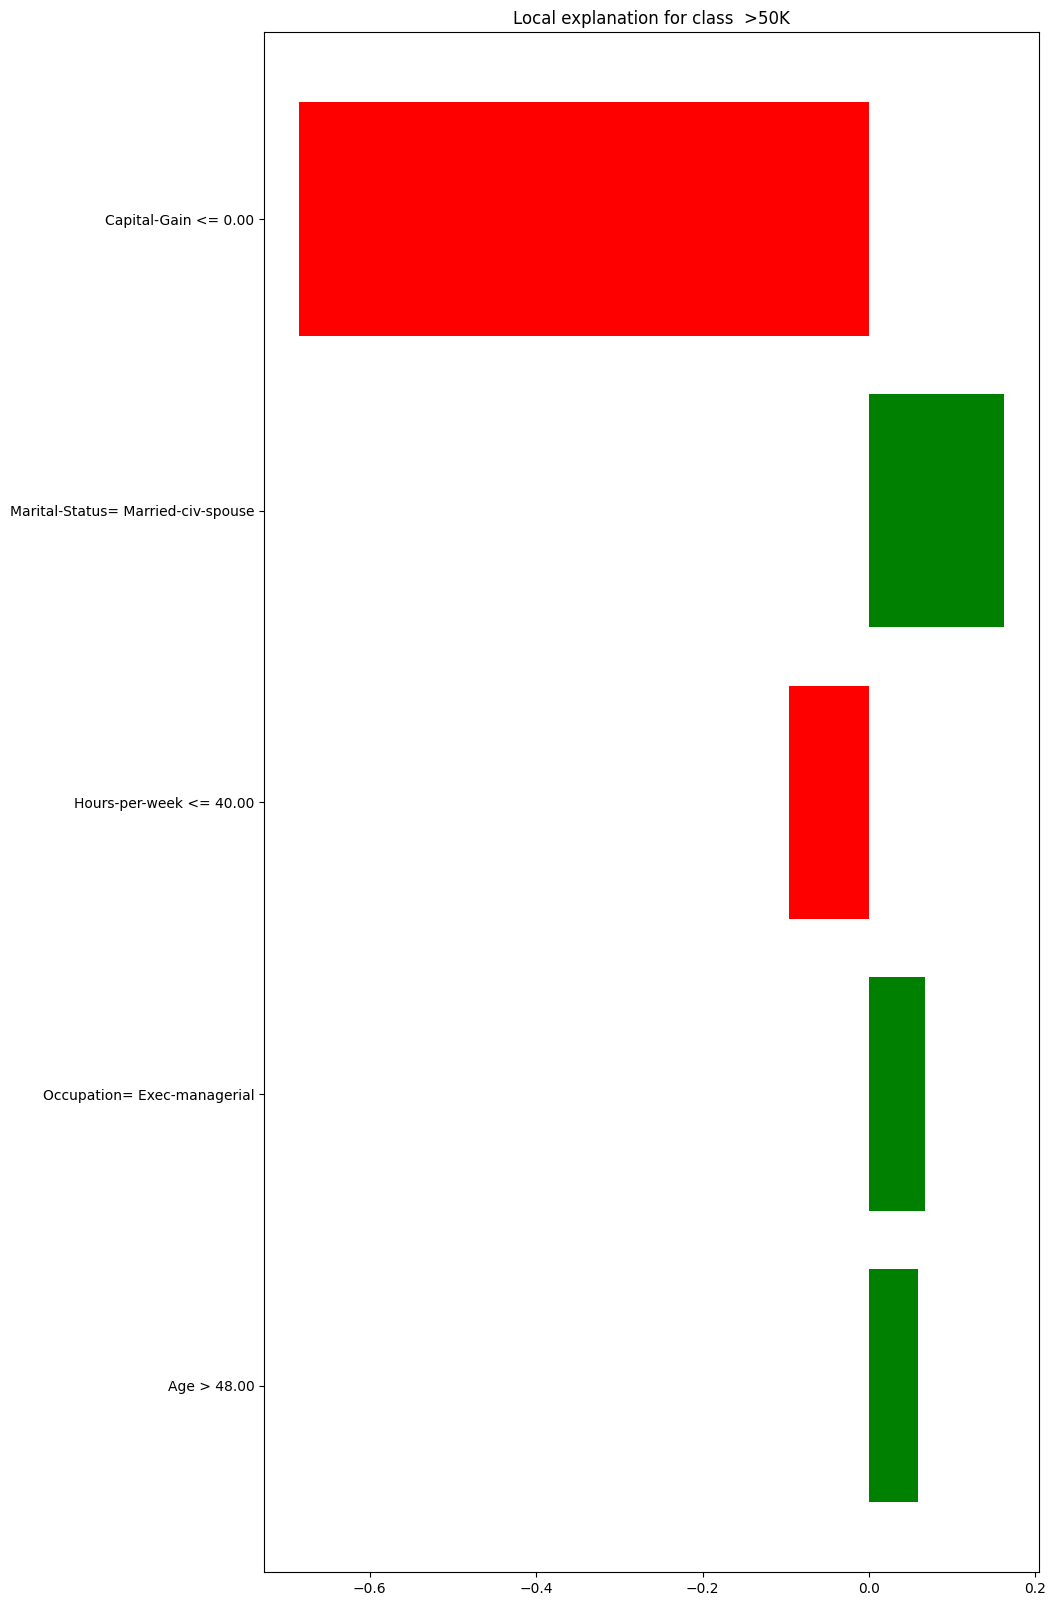

In [31]:
# Visualize the explanation 
%matplotlib inline
fig = exp.as_pyplot_figure()

The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs. You could also save the html page to a file if you wanted to.

In [32]:
exp.show_in_notebook(show_all=True)

The explanation can also be presented as a list of weighted features.

In [33]:
exp.as_list()

[('Capital-Gain <= 0.00', -0.684550388605834),
 ('Marital-Status= Married-civ-spouse', 0.162346563193886),
 ('Hours-per-week <= 40.00', -0.09655735800434503),
 ('Occupation= Exec-managerial', 0.06716683253200424),
 ('Age > 48.00', 0.058848027021909256)]

Now generate LIME explanations (in whichever format you chose) for some other examples in the test set. 
Change the value of "i" and explore some of the local explanations for other predictions

In [34]:
# Code here + add as many code cells as needed

**Questions**

1. What did we learn from this plot. How do we interpret this plot? 
2. What does it not tell us? what do red and green mean? What's on the x axis?
3. How does this explantion differ from the feature intrinsic  importance explanation given above?
4. When we changed the datapoint for which we what explanation, what happend? Are similar features important for all datapoints?
5. Who can use these explanations? Which stakeholder?
6. For what purpose(s)?


### Step 2: SP-LIME Global Explainer(for Tabular Data)

As we just saw, explanations can vary a lot depending on what instance we pick. While this is great for explaining a single prediction, it makes it hard to give someone general intuition for "how the model makes decision." That's where the submodular picker comes in. It picks useful, representative examples that together give global explanation for the model.

The algorithm to do this is as follows:
1. Calculate an explanation for all examples in the dataset
2. Determine which features are important in explaining a lot of predictions -- that is, features that seem globally important
3. Select (greedily) examples where the top globally important feature is part of the local explanation for that one example's prediction
4. Continue selecting examples until we've covered as many of the globally important features as possible, constrained by the number of features that the user wants returned (num_exps_desired)

You can read the details of how this is done in the LIME paper in BS.

In [35]:
# Initialize the SP object
sp_obj = submodular_pick.SubmodularPick(explainer, train.values, predict_fn, sample_size=10, 
                                        num_features=5, num_exps_desired=5)

X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names


KeyboardInterrupt: 

The attribute V tells us the best indices from the test set to explain the overall predictions of the classifier.

In [ ]:
sp_obj.V

Now, we can get explantions for each of those examples:

In [ ]:
for ind in sp_obj.V:
    exp = explainer.explain_instance(test.values[ind], predict_fn, num_features=5)
    print("Actual class: ", labels_test[ind])
    exp.show_in_notebook(show_all=False)
    print("==========================")

**Questions:**

Based on these (carefully chosen) examples, 
1. what can you say to someone who wanted to know how our model makes decisions?
2. How are these explanaions useful for?
3. For what purposes?


## Part III: SHAP

- Step 1: Re-load the dataset and Re-Train the model (to fit SHAP input format)
- Step 2: Create and Instentate a SHAP explainer (TreeSHAP)
- Step 3: Bar chart of mean feature importance (Global Explanations of feature importance)
- Step 4: Visualize a single prediction(s) (Local Explanation) 
- Step 5: 

### Step 1: Re-Train the model (and re-load the dataset)
We will retain the model to fit SHAP expected input format. We will download the same dataset (adult dataset) from the SHAP repositiry. The dataset containes the same data entries as the one downloaded from the original repository. But SHAP also offeres an encoded version of the data. We will use this for convinence sake but you can also work with the original data and encode your features using the tools available in sklearn library (for example).


Re-load dataset

In [38]:
# Load the adult data set from SHAP repository
X,y = shap.datasets.adult()

# Get the encoded dataset for SHAP repository 
X_display,y_display = shap.datasets.adult(display=True)


In [39]:
# create a train/test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.80, random_state=10)
# train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, train_size=0.80, random_state=10)
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)




Train shape:  (26048, 12)
Test shape:  (6513, 12)


Re-train the model (actually train a new model with the exact same features and parameters)

In [40]:
# Fit the model
gbtree_shap = xgboost.XGBClassifier(n_estimators=200, max_depth=5)
gbtree_shap.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Check accuracy of the new/re-trained model.

In [41]:
# Make predictions 
pred_labels_test = gbtree_shap.predict(X_test)
# Test accuracy again (it should be the same as the first model ~ 0.87 +/- 0.02)
print("Test set accuracy: ", sklearn.metrics.accuracy_score(y_test, pred_labels_test))

Test set accuracy:  0.8673422385997236


###Step 2: Create and Instentate a SHAP explainer (TreeSHAP)

Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset.

- Global interpretable: SHAP provides model wide relevant explanations. 
- Can be used to produce local explanations (for specific data point(s)) 
- SHAP is Model-agnostic, however TreeSHAP is Model-Specific (Decision Trees)


In [42]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(gbtree_shap)
shap_values = explainer.shap_values(X)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Step 3: Bar chart of mean feature importance (Global Explanation)

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

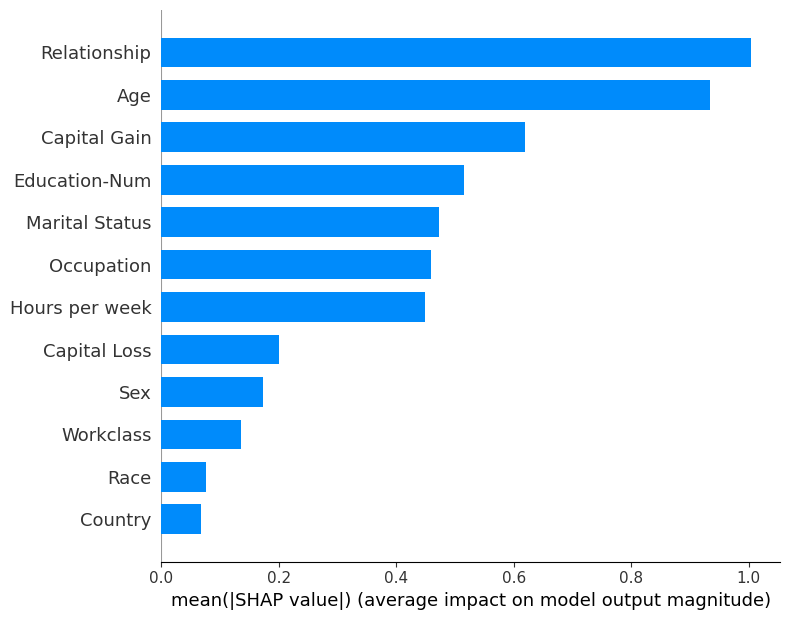

In [43]:
#Uncomment if using Colab
shap.initjs()
shap.summary_plot(shap_values, X_display, plot_type="bar")

The global mean(|Tree SHAP|) method applied to the income prediction model. The x-axis is essentially the average magnitude change in model output when a feature is “hidden” from the model (for this model the output has log-odds units). See [SHAP-related papers](https://github.com/slundberg/shap) for details, but “hidden” means integrating the variable out of the model. Since the impact of hiding a feature changes depending on what other features are also hidden, Shapley values are used to enforce consistency and accuracy.

**Questions:**


### Step 4: Visualize a single prediction (Local Explanation)


**Waterfall plot**

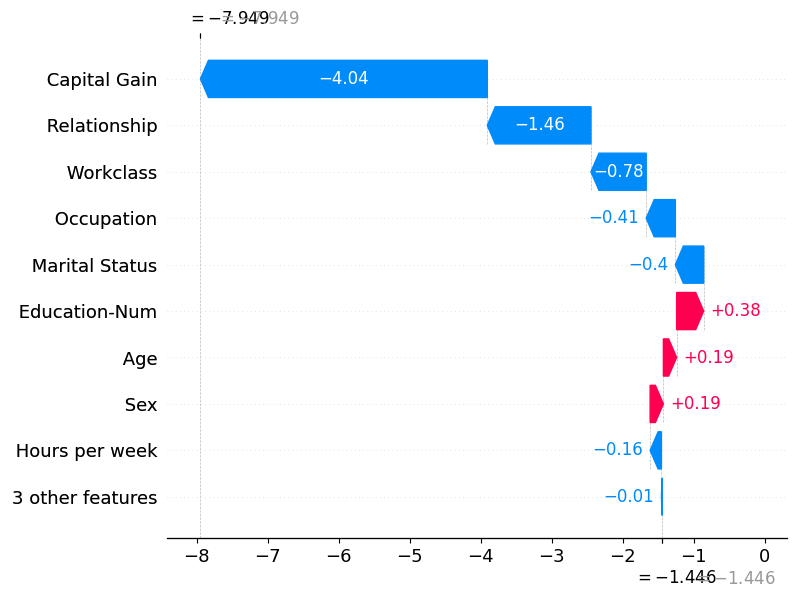

In [44]:
shap.initjs()

#i is the index of the data point of intrest
i=0
_waterfall.waterfall_legacy(explainer.expected_value, shap_values[i,:], X_display.iloc[i,:])

**How to read the plot**

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue


In the plot above, E\[F(X)\] is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. <br>
Remember Label mapping:  {' <=50K': 0, ' >50K': 1}<br>
0: the person earns 50K or Less/year (Red)<br>
1: the person earns more than 50K /year (Blue)<br>

E\[F(X)\]= -1.383 is the model baseline </br>

The plot shows how features influence the prediction with respect to the baseline by tipping the score one way or another

**TO DO**
1. Observe the explanation provided by TreeSHAP and compare it to the one Provided by LIME for the same datapoit "i=0"
2. Change the datapoint of intrest and observe the new explanation (compare it to the same i value for LIME explanation)

In [ ]:
# write the explanation code for the new data point here

**"String-like" plot**



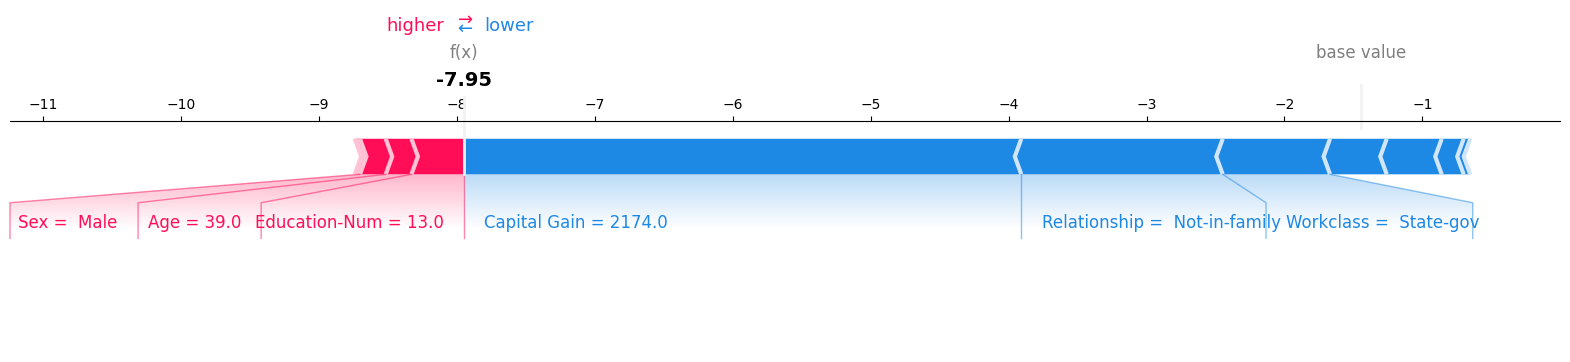

In [46]:
#Uncomment if using Colab
shap.initjs()
i=0
shap.force_plot(explainer.expected_value, shap_values[i,:], X_display.iloc[i,:], matplotlib=True )

**TO DO**
1. Change the datapoint of intrest and observe the new explanation 

In [ ]:
# write the explanation code for the new data point here

**Questions**

1. What did we learn from these two plots. How do we interpret them ? 
2. What does it not tell us? what do red and green mean? What's on the x axis?
4. When we changed the datapoint for which we what explanation, what happend? Are similar features important for all datapoints?
5. Who can use these explanations? Which stakeholder?
6. For what purpose(s)?

### Step 5: Visualize many predictions (Local Overview) or Filtered predictions (Cohort)

**Note** To keep the plot readable in the browser we only visualize data points for 1,000 individuals but you can use more.

In [47]:
#Uncomment if using Colab
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

In [ ]:
#Uncomment if using Colab
shap.initjs()
shap.summary_plot(shap_values, X)

# with Possibility to filter and/or create cohort plots
# shap.summary_plot(shap_values[:1000,:], X.iloc[:1000,:])

Tree SHAP explains the change in the margin output of the model. 
Every person (data point) has one dot on each row. The x position of the dot is the impact of that feature on the model’s prediction for the person, and the color of the dot represents the value of that feature for the person. Dots that don’t fit on the row pile up to show density (there are 32,561 customers in this example).

The features are sorted by mean(|Tree SHAP|) and so we again see the relationship feature as the strongest predictor of making over \$50K annually. By plotting the impact of a feature on every sample we can also see important outlier effects. For example, while capital gain is not the most important feature globally, it is by far the most important feature for a subset of customers. The coloring by feature value shows us patterns such as how being younger lowers your chance of making over $50K, while higher education increases your chance of making over \$50K.

### ---------------- End of the Lab ----------------